In [2]:
import numpy as np
import xarray as xr

In [3]:


# --- Load tvt mask once ---
tvt = xr.open_dataarray(
    "/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/masks/tvt_mask.nc"
)

# Boolean mask for test points
test_mask = (tvt == 2)

# If tvt has a time dimension but the mask is constant in time,
# just take one time slice to avoid carrying time everywhere.
if "time" in test_mask.dims:
    test_mask = test_mask.isel(time=0)

def open_masked(path, mask=test_mask):
    """Open a DataArray and apply the test mask."""
    da = xr.open_dataarray(path)
    return da.where(mask)

# ---------- ENSMEAN ----------
ens = {
    "gpp":     open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/ensmean_files/S3/ENSMEAN_S3_gpp.nc"),
    "cVeg":    open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/ensmean_files/S3/ENSMEAN_S3_cVeg.nc"),
    "cLitter": open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/ensmean_files/S3/ENSMEAN_S3_cLitter.nc"),
    "cSoil":   open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/ensmean_files/S3/ENSMEAN_S3_cSoil.nc"),
}

# ---------- Base teacher ----------
base = {
    "gpp":     open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/base_vs_ensmean_scenarios/S3/DATA/gpp/ENSMEAN/ENSMEAN_S3_gpp.nc"),
    "cVeg":    open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/base_vs_ensmean_scenarios/S3/DATA/cVeg/ENSMEAN/ENSMEAN_S3_cVeg.nc"),
    "cLitter": open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/base_vs_ensmean_scenarios/S3/DATA/cLitter/ENSMEAN/ENSMEAN_S3_cLitter.nc"),
    "cSoil":   open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/base_vs_ensmean_scenarios/S3/DATA/cSoil/ENSMEAN/ENSMEAN_S3_cSoil.nc"),
}

# ---------- Base carry ----------
base_carry = {
    "gpp":     open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/base_model/S3/gpp.nc"),
    "cVeg":    open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/base_model/S3/cVeg.nc"),
    "cLitter": open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/base_model/S3/cLitter.nc"),
    "cSoil":   open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/base_model/S3/cSoil.nc"),
}

# ---------- Stable carry ----------
stable_carry = {
    "gpp":     open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/32_year/gpp.nc"),
    "cVeg":    open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/32_year/cVeg.nc"),
    "cLitter": open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/32_year/cLitter.nc"),
    "cSoil":   open_masked("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/32_year/cSoil.nc"),
}

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def scatter(
    x, y,
    time=None,
    title="",
    xlabel="",
    ylabel="",
    point_size=10,
    xmin=None, xmax=None,
    ymin=None, ymax=None,
    density_=1.0,
    bins=100,
    cmap_min_year=1901,
    cmap_max_year=2023,
    max_points=200_000,     # <<< NEW
):
    """
    Fast scatter plot with:
      - density-based transparency
      - optional time-based colouring
      - optional subsampling (max_points)
    """
    # --- Convert to numpy ---
    x = np.asarray(x)
    y = np.asarray(y)

    # --- Broadcast x, y, time ---
    if time is not None:
        time = np.asarray(time)
        x, y, time = np.broadcast_arrays(x, y, time)

        if (np.issubdtype(time.dtype, np.number) or
            np.issubdtype(time.dtype, np.datetime64)):
            mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(time)
        else:
            mask = np.isfinite(x) & np.isfinite(y)
    else:
        x, y = np.broadcast_arrays(x, y)
        mask = np.isfinite(x) & np.isfinite(y)

    # --- Apply mask ---
    x = x[mask]
    y = y[mask]
    if time is not None:
        time = time[mask]

    # --- Subsample (NEW) ---
    N = x.size
    if max_points is not None and N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)
        x = x[idx]
        y = y[idx]
        if time is not None:
            time = time[idx]

    if x.size == 0:
        raise ValueError("No valid points to plot after masking/subsampling.")

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

    # --- Determine axis limits ---
    x_min = x.min() if xmin is None else xmin
    x_max = x.max() if xmax is None else xmax
    y_min = y.min() if ymin is None else ymin
    y_max = y.max() if ymax is None else ymax

    # Avoid zero-width extent
    if x_min == x_max:
        x_min -= 0.5; x_max += 0.5
    if y_min == y_max:
        y_min -= 0.5; y_max += 0.5

    # --- Compute 2D histogram ---
    H, xedges, yedges = np.histogram2d(
        x, y, bins=bins,
        range=[[x_min, x_max], [y_min, y_max]]
    )

    # Map each point to bin index
    x_idx = np.searchsorted(xedges, x, side="right") - 1
    y_idx = np.searchsorted(yedges, y, side="right") - 1
    x_idx = np.clip(x_idx, 0, bins - 1)
    y_idx = np.clip(y_idx, 0, bins - 1)

    density = H[x_idx, y_idx].astype(float)
    density_norm = (density - density.min()) / (density.max() - density.min() + 1e-9)
    density_scaled = density_norm ** (1 / max(density_, 1e-9))
    alpha = 0.05 + 0.7 * density_scaled

    # --- Convert time to year for colouring ---
    scatter_kwargs = dict(s=point_size, alpha=alpha)

    if time is not None:
        # datetime64
        if np.issubdtype(time.dtype, np.datetime64):
            years = time.astype("datetime64[Y]").astype(int) + 1970

        elif np.issubdtype(time.dtype, np.number):
            tmin, tmax = np.nanmin(time), np.nanmax(time)
            if 1800 <= tmin <= 3000:
                years = time
            else:
                years = 1901 + (time.astype(float) // 365).astype(int)

        else:
            years = np.array([getattr(t, "year", np.nan) for t in time])
            good = np.isfinite(years)
            x, y, alpha, years = x[good], y[good], alpha[good], years[good]

        norm = plt.Normalize(cmap_min_year, cmap_max_year)
        sc = ax.scatter(x, y, c=years, cmap="cividis", norm=norm, **scatter_kwargs)
        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label("Year")
    else:
        ax.scatter(x, y, color="blue", **scatter_kwargs)

    # --- 1:1 line ---
    lim_min = min(x_min, y_min)
    lim_max = max(x_max, y_max)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], "--", color="red", linewidth=1)

    # --- Axis limits ---
    ax.set_xlim(x_min if xmin is None else xmin, x_max if xmax is None else xmax)
    ax.set_ylim(y_min if ymin is None else ymin, y_max if ymax is None else ymax)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

    return fig, ax

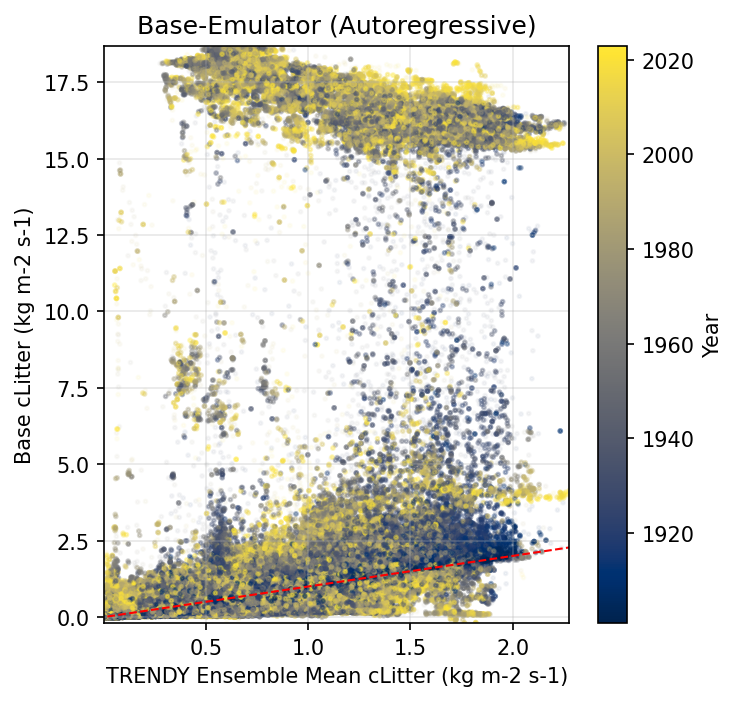

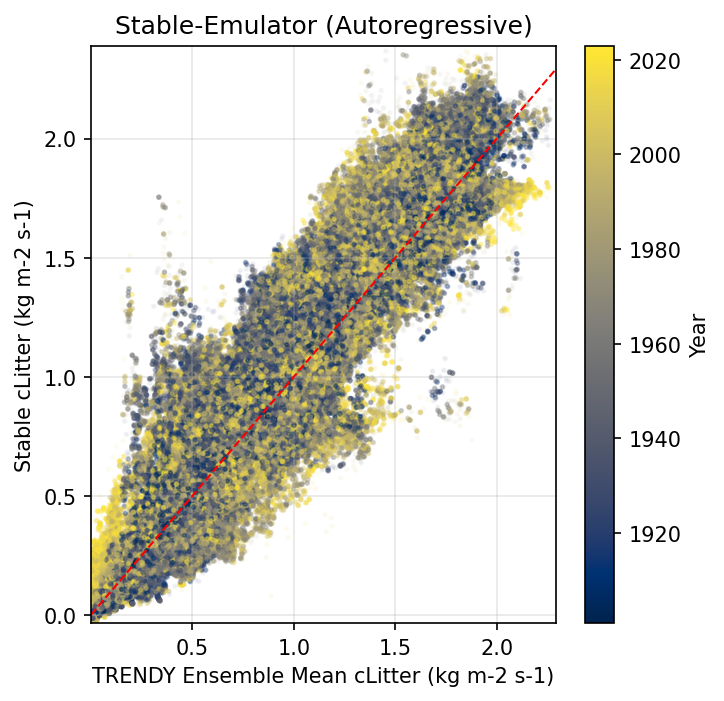

In [5]:
# Base
da_ens = ens['cLitter']         # masked ENS
da_model = base_carry['cLitter']

time_days = da_ens['time'].values      # cftime.DatetimeNoLeap
time_3d = time_days[:, None, None]     # (time, 1, 1) → broadcasts

fig, ax = scatter(
    da_ens.values,
    da_model.values,
    time=time_3d,
    title="Base-Emulator (Autoregressive)",
    xlabel="TRENDY Ensemble Mean cLitter (kg m-2 s-1)",
    ylabel="Base cLitter (kg m-2 s-1)",
    point_size=3,
    density_=10,
    max_points=200_000,
)
# Stable
da_ens = ens['cLitter']         # masked ENS
da_model = stable_carry['cLitter']

time_days = da_ens['time'].values      # cftime.DatetimeNoLeap
time_3d = time_days[:, None, None]     # (time, 1, 1) → broadcasts

fig, ax = scatter(
    da_ens.values,
    da_model.values,
    time=time_3d,
    title="Stable-Emulator (Autoregressive)",
    xlabel="TRENDY Ensemble Mean cLitter (kg m-2 s-1)",
    ylabel="Stable cLitter (kg m-2 s-1)",
    point_size=3,
    density_=10,
    max_points=200_000,
)

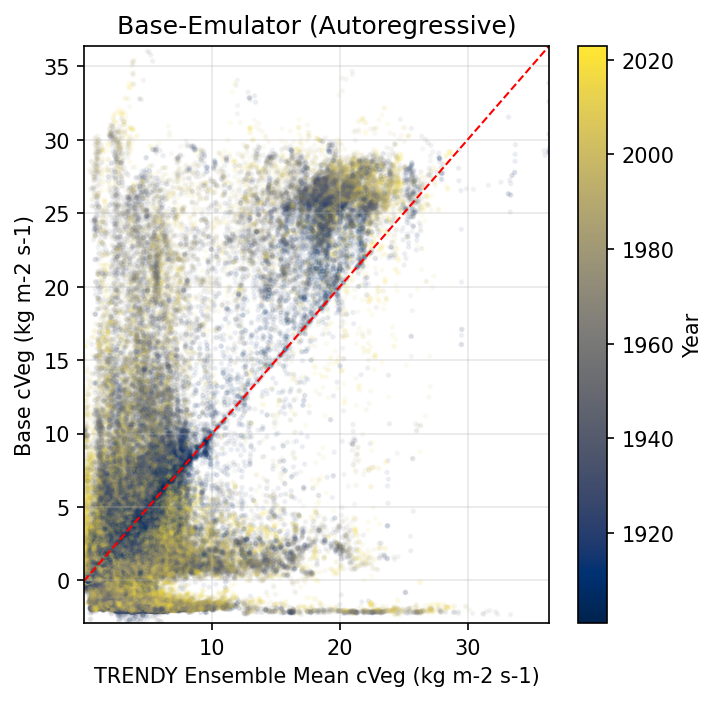

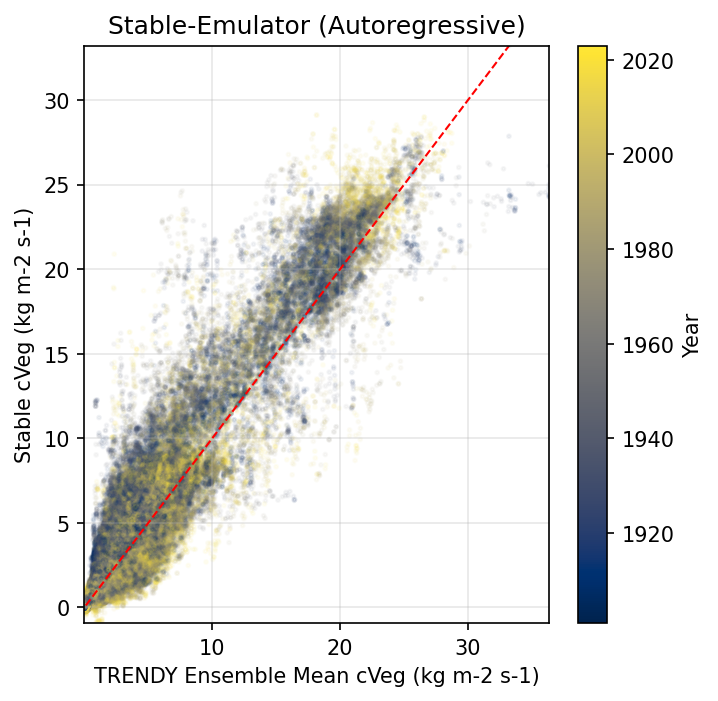

In [6]:
# Base
da_ens = ens['cVeg']         # masked ENS
da_model = base_carry['cVeg']

time_days = da_ens['time'].values      # cftime.DatetimeNoLeap
time_3d = time_days[:, None, None]     # (time, 1, 1) → broadcasts

fig, ax = scatter(
    da_ens.values,
    da_model.values,
    time=time_3d,
    title="Base-Emulator (Autoregressive)",
    xlabel="TRENDY Ensemble Mean cVeg (kg m-2 s-1)",
    ylabel="Base cVeg (kg m-2 s-1)",
    point_size=3,
    density_=2,
    max_points=200_000,
)
# Stable
da_ens = ens['cVeg']         # masked ENS
da_model = stable_carry['cVeg']

time_days = da_ens['time'].values      # cftime.DatetimeNoLeap
time_3d = time_days[:, None, None]     # (time, 1, 1) → broadcasts

fig, ax = scatter(
    da_ens.values,
    da_model.values,
    time=time_3d,
    title="Stable-Emulator (Autoregressive)",
    xlabel="TRENDY Ensemble Mean cVeg (kg m-2 s-1)",
    ylabel="Stable cVeg (kg m-2 s-1)",
    point_size=3,
    density_=2,
    max_points=200_000,
)